In [4]:
%pylab inline
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif',\
        font_scale=1.5, color_codes=False, rc=None)

Populating the interactive namespace from numpy and matplotlib


In [5]:
import mysql.connector
import pandas as pd
import pickle as pk
import sys

In [6]:
db_connection = mysql.connector.connect(user='root',
                             password='root',
                             host='localhost',
                             database='comic_books')

# First, let's see how far back the data coverage goes:

In [199]:
query0 = ('''
            SELECT MIN(year_began)
            FROM gcd_series 
        ''')

df = pd.read_sql(query0, con=db_connection)
df

,MIN(year_began)
0,0


We actually have $year = 0$, which probably is a typo so next we remove that and re-run the query.

In [200]:
query0 = ('''
            SELECT year_began 
            FROM gcd_series 
            WHERE year_began >0
            ORDER BY  year_began  ASC;
        ''')
df = pd.read_sql(query0, con=db_connection)
print ("Database includes books from %s to %s." %(str(df.year_began.min()), str(df.year_began.max())))

Database includes books from 198 to 9999.


Again the min year-began is 198 ( perhaps a mistake for 198?). At this point, I'm going to assume anything before 1940s could not be valid.

In [319]:
query0 = ('''
            SELECT year_began 
            FROM gcd_series 
            WHERE year_began BETWEEN 1940 AND 2017
            ORDER BY year_began ASC;
            ''')

df = pd.read_sql(query0, con=db_connection)

print ("Database includes books from %s to %s." %(str(df.year_began.min()), str(df.year_began.max())))

Database includes books from 1940 to 2017.


In [318]:
df.head(2)

,issue_id,title,sequence_number,key_date,name
0,167174,Bye Bye Birdy,0,2004-09-00,DC Comics
1,167174,New Blood Part One: Moving Day,1,2004-09-00,DC Comics


# 1. Let's look at the number of issues published per year

In [320]:
query0 = ('''
            SELECT year_began , COUNT(*)
            FROM gcd_series 
            WHERE year_began BETWEEN 1940 AND 2017
            GROUP BY year_began            
        ''')
df = pd.read_sql(query0, con=db_connection)
print ("Database includes books from %s to %s." %(str(df.year_began.min()), str(df.year_began.max())))

Database includes books from 1940 to 2017.


In [321]:
df.head(2)

,year_began,COUNT(*)
0,1940,231
1,1941,152


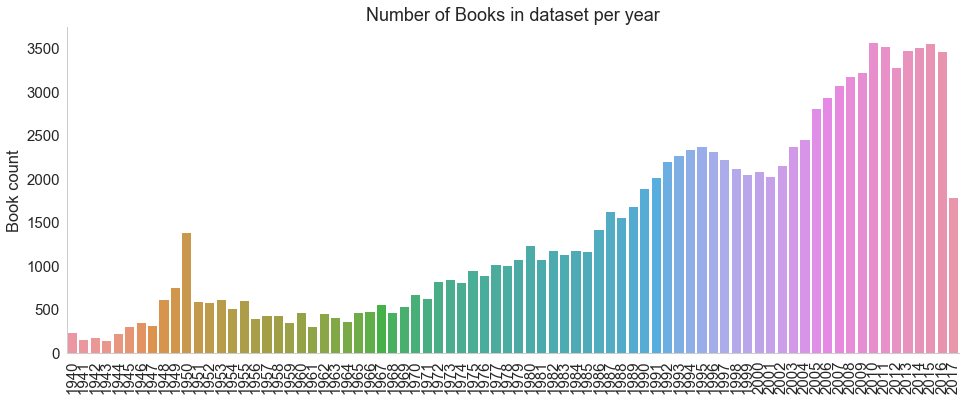

In [254]:
figure(figsize=(16,6))
ax = sns.barplot(x='year_began', y ='COUNT(*)', data=df)
ax.set_xlabel(' ')
ax.set_ylabel('Book count')
plt.xticks(rotation=90, ha='center', );

ax.set_title('Number of Books in dataset per year')
ax.grid(0)
sns.despine(left=False, top=True, bottom=False, right=True)

# Conclusion 1: 
The number of books grows with a pick around 1990 and one around 2010. The increasing trend could be due to both the increase in the publication industry as well as the easier accessibility to more recent material.

# 2. Distribution of books per language

Next we would like to look at the number of __languages__ presentted in the data and how many issues (comic books) are recorded per language. For this we need to merge two tables, since in gcd_series languages are encoded with integer ids. We merge with stddata_language and map names to ids.

In [327]:
query1 = ('''
            SELECT lan.`name` as Language, COUNT(*)
            FROM gcd_series g, stddata_language lan
            WHERE g.`language_id` = lan.`id`
            GROUP BY lan.`name`
            ORDER BY COUNT(*) DESC;
            
        ''')
df = pd.read_sql(query1, con=db_connection)

In [328]:
'''
Remove unvalid languages
'''
df = df.replace('(no linguistic content)', np.nan).replace('(undetermined)', np.nan).dropna()

In [329]:
df.head(2)

,Language,COUNT(*)
0,English,64647
1,German,15282


In [332]:
print('%s unique languages in the dataset.' %str(len(df.Language.unique())))

89 unique languages in the dataset.


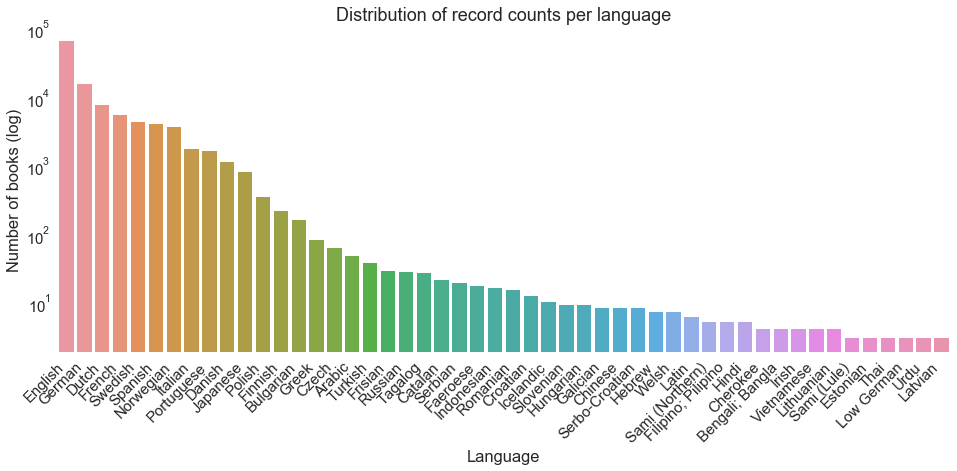

In [333]:
figure(figsize=(16,6))
'''
Only dispalying the top 50 languages
'''
ax = sns.barplot(df[:50].Language, df[:50]['COUNT(*)'])
ax.set_ylabel('Number of books (log)')
ax.set_title('Distribution of record counts per language')
ax.set_yscale('log')
plt.xticks(rotation=45, ha='right');
ax.set_frame_on(0)
ax.grid(0)

# Conclusion 2:
English comic books are significanlty more popualr in the dataset than other languages. The fact that the website is an English language could be the reason that the data is a bit skewed.

# 3. We look at the number of publisher per country

In [334]:
query2 = ('''
            SELECT p.`name` as 'Publisher', c.`name` as 'Country'
            FROM gcd_publisher p, stddata_country c
            WHERE p.`country_id` = c.`id`
        ''')
df = pd.read_sql(query2, con=db_connection)

In [335]:
df.head(2)

,Publisher,Country
0,"Roberts Brothers, Boston",United States
1,"Sampson Low, Son, and Marston, Milton House; L...",United Kingdom


In [336]:
print('%s unique publishers.'%str(len(df.Publisher.unique())))

10441 unique publishers.


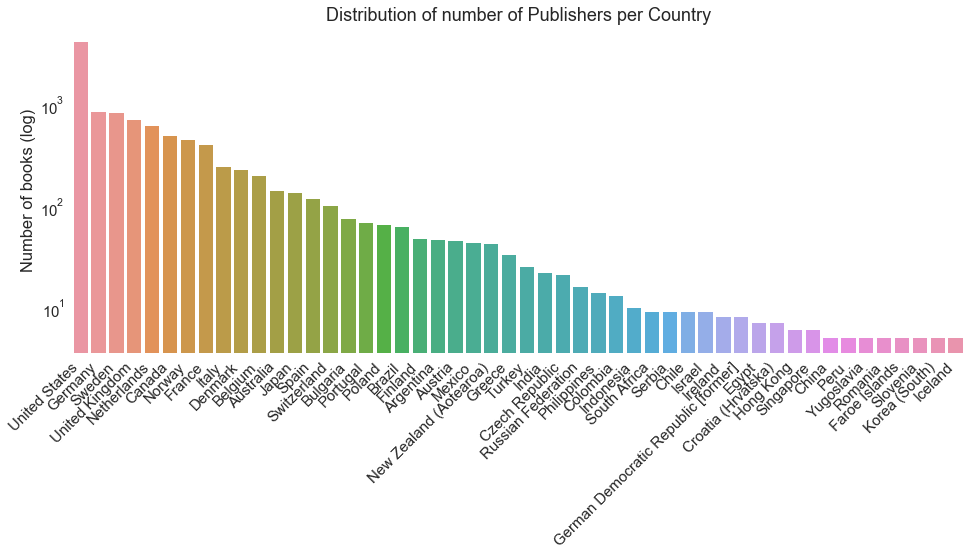

In [337]:
figure(figsize=(16,6))
'''
Only dispalying the top 50 countries with most unique publisher 
'''
counts = df.Country.value_counts()[:50]
ax = sns.barplot(counts.index, counts.values)
ax.set_ylabel('Number of books (log)')
ax.set_title('Distribution of number of Publishers per Country')
ax.set_yscale('log')
plt.xticks(rotation=45, ha='right');
ax.set_frame_on(0)
ax.grid(0)

# Conclusion 3:
__United states__ have the most number of unique pubishers, followd by __Germany__ and __Sweden__.

# 4. Only look at US publishers, how many of them exist and distributoin of issues per publishers

In [338]:
query3 = '''
            SELECT p.`id`, p.`name` as 'Publisher'	, c.`name` as 'Country'
            FROM gcd_indicia_publisher p, stddata_country c
            WHERE c.`name` = 'United States' and p.`country_id` = c.`id`
        '''
df = pd.read_sql(query3, con=db_connection)

In [339]:
print "%s unique publisher names in USA."%len(df)

2771 unique publisher names in USA.


In [8]:
query5 = '''
            SELECT p.`name` as 'Publisher', COUNT(*)
            FROM gcd_series s, gcd_publisher p
            WHERE p.`id` = s.`publisher_id` and s.`publisher_id` IN 
                (SELECT p.`id`
                FROM gcd_indicia_publisher p, stddata_country c
                WHERE c.`name` = 'United States' and p.`country_id` = c.`id`
                )
            
            GROUP BY p.`name`
            ORDER BY COUNT(*) DESC
        '''
df = pd.read_sql(query5, con=db_connection)

In [341]:
df.head(3)

,Publisher,COUNT(*)
0,DC,7215
1,Panini Deutschland,1944
2,IDW,1448


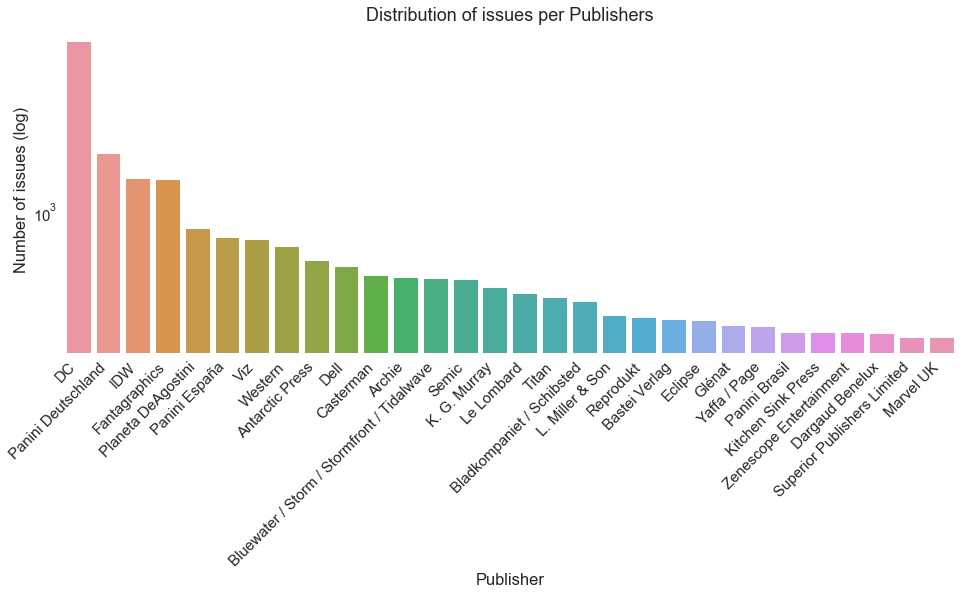

In [343]:
figure(figsize=(16,6))
'''
Only dispalying the top 20 languages
'''
ax = sns.barplot(df[:30].Publisher, df[:30]['COUNT(*)'])
ax.set_ylabel('Number of issues (log)')
ax.set_title('Distribution of issues per Publishers')
ax.set_yscale('log')
plt.xticks(rotation=45, ha='right');
ax.set_frame_on(0)
ax.grid(0)

Finally sales data only includes comics from US and after 2003 so here is simple mysql query to get comic books published by a US publisher after 2003.

In [344]:
query = ('''
            SELECT s.`issue_id`, s.`title`,  s.`sequence_number`, g.`key_date`, p.`name`
            FROM gcd_story s, gcd_issue g
            LEFT JOIN 
                gcd_indicia_publisher AS p
                ON  p.id = g.`indicia_publisher_id`
                AND p.`country_id`=225
            WHERE ( s.`issue_id` = g.`id` and  g.`key_date`>2003) 
        ''')


In [345]:
df = pd.read_sql(query, con=db_connection)

In [346]:
df.head(3)

,issue_id,title,sequence_number,key_date,name
0,167174,Bye Bye Birdy,0,2004-09-00,DC Comics
1,167174,New Blood Part One: Moving Day,1,2004-09-00,DC Comics
2,167330,,0,2004-05-00,None


In [347]:
'''
Some books have no publisher name
'''
df['name'].replace('None', 'No_Publisher', inplace=True)

In [348]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

In [349]:
'''
Remove the redundant word Commic from publisher name for the reasons
of matching with sale data as it does not appear in book sale data.
'''

df['Publisher'] = df['name'].apply(lambda l: str(l).replace('Comics', ''))

In [350]:
df.head(3)

,issue_id,title,sequence_number,key_date,name,Publisher
0,167174,Bye Bye Birdy,0,2004-09-00,DC Comics,DC
1,167174,New Blood Part One: Moving Day,1,2004-09-00,DC Comics,DC
2,167330,,0,2004-05-00,None,None


Save copies of the dataframe in pickle and platform independent __CSV__ format.

In [9]:
import pickle as pk
pk.dump(df, open('../Datasets/gcd_book_uscomics_after2004.pkl', 'wb'), protocol = 2)
df.to_csv('gcd_book_uscomics_after2004_df.csv', sep=',', encoding='utf-8')